# Bike Sharing Demand
- Forecast use of a city bikeshare system
- https://www.kaggle.com/c/bike-sharing-demand/data

## Credit to:
- 

In [107]:
# data processing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt
from scipy import stats
from scipy.stats import norm
import math
# ML
# # Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
# # XGB
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
# # CatBoost
#from catboost import Pool, CatBoostRegressor, cv, CatboostIpythonWidget
# System
import datetime as dt
from datetime import datetime
import sys
from inspect import getsourcefile
import os.path
import re

# Other
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Input data files are available in the DATA_DIR directory.
DATA_DIR = "data-temp"

# Load data

In [2]:
# Load data. Download from:https://www.kaggle.com/c/bike-sharing-demand/data
train_data = pd.read_csv(DATA_DIR + "/train.csv")
eval_data =  pd.read_csv(DATA_DIR + "/test.csv")

In [3]:
train_data.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
eval_data.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Combine train data and eval data

In [83]:
label = 'count'
features = eval_data.columns.values
target = train_data[label].values
combine_data = pd.concat([train_data[features], eval_data], keys=['train','eval'])
combine_data.head(5)

datetime  season  holiday  workingday  weather  temp  \
train 0  2011-01-01 00:00:00       1        0           0        1  9.84   
      1  2011-01-01 01:00:00       1        0           0        1  9.02   
      2  2011-01-01 02:00:00       1        0           0        1  9.02   
      3  2011-01-01 03:00:00       1        0           0        1  9.84   
      4  2011-01-01 04:00:00       1        0           0        1  9.84   

          atemp  humidity  windspeed  
train 0  14.395        81        0.0  
      1  13.635        80        0.0  
      2  13.635        80        0.0  
      3  14.395        75        0.0  
      4  14.395        75        0.0

# Pre-process data

### Check NaN columns

In [6]:
def check_null_data(data):
    #Get high percent of NaN data
    null_data = combine_data.isnull()
    total = null_data.sum().sort_values(ascending=False)
    percent = (null_data.sum()/null_data.count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    high_percent_miss_data = missing_data[missing_data['Percent']>0]
    #print(missing_data)
    print(high_percent_miss_data)
    miss_data_cols = high_percent_miss_data.index.values
    return miss_data_cols

In [7]:
# Check target for null
check_null_data(target)

Empty DataFrame
Columns: [Total, Percent]
Index: []


array([], dtype=object)

In [8]:
# combine data for null
check_null_data(combine_data)

Empty DataFrame
Columns: [Total, Percent]
Index: []


array([], dtype=object)

In [9]:
combine_data.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object

### Convert datetime string to object

In [84]:
date_format = "%Y-%m-%d %H:%M:%S"
data = combine_data
data['datetime_obj'] = data['datetime'].apply(lambda x: datetime.strptime(x, date_format))
data['datetime_obj'][:5]

train  0   2011-01-01 00:00:00
       1   2011-01-01 01:00:00
       2   2011-01-01 02:00:00
       3   2011-01-01 03:00:00
       4   2011-01-01 04:00:00
Name: datetime_obj, dtype: datetime64[ns]

### Extract date component from datatime object

In [85]:
data['year'] = data['datetime_obj'].apply(lambda x: x.year)
data['month'] = data['datetime_obj'].apply(lambda x: x.month)
data['day'] = data['datetime_obj'].apply(lambda x: x.day)
data['hour'] = data['datetime_obj'].apply(lambda x: x.hour)
data[:5]

datetime  season  holiday  workingday  weather  temp  \
train 0  2011-01-01 00:00:00       1        0           0        1  9.84   
      1  2011-01-01 01:00:00       1        0           0        1  9.02   
      2  2011-01-01 02:00:00       1        0           0        1  9.02   
      3  2011-01-01 03:00:00       1        0           0        1  9.84   
      4  2011-01-01 04:00:00       1        0           0        1  9.84   

          atemp  humidity  windspeed        datetime_obj  year  month  day  \
train 0  14.395        81        0.0 2011-01-01 00:00:00  2011      1    1   
      1  13.635        80        0.0 2011-01-01 01:00:00  2011      1    1   
      2  13.635        80        0.0 2011-01-01 02:00:00  2011      1    1   
      3  14.395        75        0.0 2011-01-01 03:00:00  2011      1    1   
      4  14.395        75        0.0 2011-01-01 04:00:00  2011      1    1   

         hour  
train 0     0  
      1     1  
      2     2  
      3     3  
      4     4

### Drop unuse cols

In [86]:
data.drop(['datetime', 'datetime_obj'], axis=1, inplace=True)
data[:5]

season  holiday  workingday  weather  temp   atemp  humidity  \
train 0       1        0           0        1  9.84  14.395        81   
      1       1        0           0        1  9.02  13.635        80   
      2       1        0           0        1  9.02  13.635        80   
      3       1        0           0        1  9.84  14.395        75   
      4       1        0           0        1  9.84  14.395        75   

         windspeed  year  month  day  hour  
train 0        0.0  2011      1    1     0  
      1        0.0  2011      1    1     1  
      2        0.0  2011      1    1     2  
      3        0.0  2011      1    1     3  
      4        0.0  2011      1    1     4

# Exploring data

### Split train_set and eval_set

In [87]:
train_set = data.loc['train']
eval_set = data.loc['eval']
data = train_set.astype(float)
data[label] = target
data[:5]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,count
0,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0,2011.0,1.0,1.0,0.0,16
1,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,2011.0,1.0,1.0,1.0,40
2,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,2011.0,1.0,1.0,2.0,32
3,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,2011.0,1.0,1.0,3.0,13
4,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,2011.0,1.0,1.0,4.0,1


### Feature correlation

In [14]:
correlation = data.corr()[label].sort_values()[-20:]
correlation

humidity     -0.317371
weather      -0.128655
holiday      -0.005393
workingday    0.011594
day           0.019826
windspeed     0.101369
season        0.163439
month         0.166862
year          0.260403
atemp         0.389784
temp          0.394454
hour          0.400601
count         1.000000
Name: count, dtype: float64

['count' 'hour' 'temp' 'atemp' 'year' 'month' 'season' 'windspeed' 'day'
 'workingday']


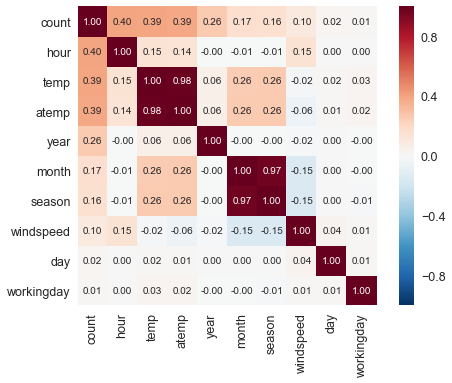

In [15]:
#correlation matrix
corrmat = data.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, label)[label].index
print(cols.values)
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

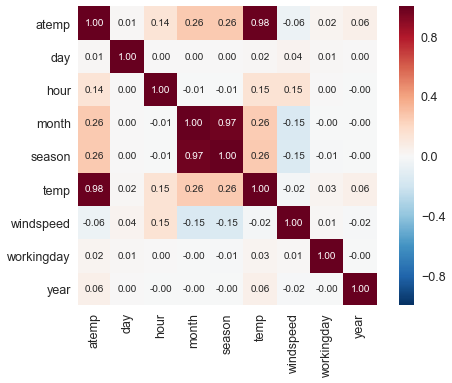

In [16]:
# Correlation matrix of cols except label
other_cols = np.setdiff1d(cols.values, label)
cm = np.corrcoef(data[other_cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=other_cols, xticklabels=other_cols)
plt.show()

# Train model

### Split train/test set

In [88]:
data = train_set.astype(float)
X_train, X_test, Y_train, Y_test = train_test_split(data, target, train_size=0.85, random_state=1234)
print("X_train:", X_train.shape, " Y_train:", Y_train.shape, " X_test:", X_test.shape, " Y_test:", Y_test.shape)

X_train: (9253, 12)  Y_train: (9253,)  X_test: (1633, 12)  Y_test: (1633,)


In [55]:
X_train[:5]

array([[  2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          3.00000000e+00,   2.62400000e+01,   2.87900000e+01,
          8.90000000e+01,   1.69979000e+01,   2.01200000e+03,
          6.00000000e+00,   1.20000000e+01,   1.40000000e+01],
       [  2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   2.78800000e+01,   3.18200000e+01,
          8.30000000e+01,   1.90012000e+01,   2.01100000e+03,
          6.00000000e+00,   1.20000000e+01,   1.60000000e+01],
       [  3.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   3.52600000e+01,   4.01500000e+01,
          4.70000000e+01,   1.90012000e+01,   2.01200000e+03,
          8.00000000e+00,   3.00000000e+00,   1.30000000e+01],
       [  3.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   3.36200000e+01,   3.93950000e+01,
          5.60000000e+01,   7.00150000e+00,   2.01200000e+03,
          9.00000000e+00,   5.00000000e+00,   1.40000000e+01],
    

### Model definition & training

In [97]:
# A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
# credit: https://www.kaggle.com/marknagelberg/rmsle-function
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(math.fabs(y_pred[i]) + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    #for i, pred in enumerate(y_pred):
    #    print("i:", i, " pred:", y_pred[i])
    #    print(math.log(y_pred[i] + 1))
    #    print(math.log(y[i] + 1))
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [131]:
#model = CatBoostRegressor(iterations=100, depth=5, thread_count=4, use_best_model=True)
model = XGBRegressor(n_estimators=1000, max_depth=5, n_jobs = -1)

### Cross validate

In [132]:
dtrain = xgb.DMatrix(data,label=target, feature_names=data.columns.values)
params = model.get_xgb_params()
cvresults = xgb.cv(params, dtrain, num_boost_round=params['n_estimators'], nfold=5, early_stopping_rounds=50, verbose_eval=50)

[0]	train-rmse:241.551+0.512859	test-rmse:241.579+2.00941
[50]	train-rmse:48.5656+0.772311	test-rmse:51.8164+1.49163
[100]	train-rmse:40.4343+0.685221	test-rmse:45.764+1.53733
[150]	train-rmse:37.2466+0.66191	test-rmse:44.1884+1.62025
[200]	train-rmse:35.244+0.598661	test-rmse:43.4243+1.6559
[250]	train-rmse:33.6183+0.553631	test-rmse:42.9467+1.6669
[300]	train-rmse:32.0053+0.603181	test-rmse:42.479+1.62074
[350]	train-rmse:30.5457+0.515525	test-rmse:42.1382+1.68824
[400]	train-rmse:29.2301+0.373342	test-rmse:41.7774+1.73301
[450]	train-rmse:28.188+0.337303	test-rmse:41.598+1.72677
[500]	train-rmse:27.2147+0.33121	test-rmse:41.4852+1.70145
[550]	train-rmse:26.4219+0.401742	test-rmse:41.4055+1.69826
[600]	train-rmse:25.5847+0.405104	test-rmse:41.2774+1.68177
[650]	train-rmse:24.807+0.443091	test-rmse:41.1557+1.67664
[700]	train-rmse:24.1328+0.422777	test-rmse:41.0185+1.6465
[750]	train-rmse:23.4517+0.427013	test-rmse:40.9178+1.65546
[800]	train-rmse:22.8439+0.451484	test-rmse:40.8585+1.

In [135]:
print(cvresults.shape[0])
print(cvresults[-5:])
#print(cvresults.index.values)

882
     test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
877       40.773623       1.689772        21.906777        0.411461
878       40.773194       1.689671        21.900364        0.412131
879       40.769582       1.685880        21.889452        0.413488
880       40.767694       1.683065        21.872825        0.415585
881       40.763941       1.685170        21.858009        0.419664


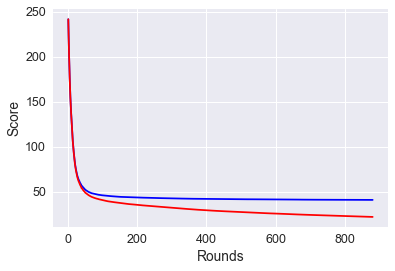

In [141]:
# plot cross validate
plt.plot(cvresults.index.values, cvresults['test-rmse-mean'], c='b', label='test')
plt.plot(cvresults.index.values, cvresults['train-rmse-mean'], c='r', label='train')
plt.xlabel('Rounds')
plt.ylabel('Score')
plt.show()


### Tuning param after CV

In [143]:
model.set_params(n_estimators=cvresults.shape[0])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=882,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Train data

In [144]:
model.fit(
    X_train, Y_train,   
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=882,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Predict for test data

In [145]:
y_pred = model.predict(X_test)
y_pred[:5]

array([ 208.43280029,   75.07782745,   80.49258423,   12.74652195,
        330.62808228], dtype=float32)

In [146]:
# Evaluate score
score = rmsle(Y_test, y_pred)
print("RMSLE score:", score)

RMSLE score: 0.3926908068419763


# Predict and save submission

In [147]:
Y_eval = np.absolute(model.predict(eval_set))
print(Y_eval[:5])

[ 17.63792992   0.43015599   4.13809109   1.68408465   1.53951454]


In [148]:
eval_output = pd.DataFrame({'datetime': eval_data['datetime'], 'count': Y_eval})
print(len(eval_output))
eval_output.head()

6493


,count,datetime
0,17.637930,2011-01-20 00:00:00
1,0.430156,2011-01-20 01:00:00
2,4.138091,2011-01-20 02:00:00
3,1.684085,2011-01-20 03:00:00
4,1.539515,2011-01-20 04:00:00


In [149]:
today = str(dt.date.today())
print(today)
eval_output.to_csv(DATA_DIR +'/' +today+'-submission.csv',index=False)

2017-07-20
